In [1]:
# FM Hasib 
# 05/24/2021

# Importing Frequently Used Libraries:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import urllib.request as ul
from scipy import stats
from scipy.stats import linregress
import scipy.optimize as sco

# Set Pandas To Display 4 Decimal Places:
pd.options.display.float_format = '{:,.4f}'.format

# Define List Of Tickers To Download Data For:
ul.urlretrieve('https://www.ssga.com/us/en/institutional/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-mdy.xlsx', 'mdy_holding.xsls')
excel = pd.DataFrame(pd.read_excel('mdy_holding.xsls', header=4))
tickers = list(excel['Ticker'].dropna())

In [2]:
# Retrieve historical data for the past 5 years. 
start = dt.datetime.today() - dt.timedelta(1825)
end = dt.datetime.today()

# download the neccessary data
data = yf.download(tickers, start, end)['Adj Close'].dropna(axis=1, how='all')
volume = yf.download(tickers, start , end)['Volume'].dropna(axis=1, how= 'all')

# calculate the return:
returns = np.log(data / data.shift()).resample('M').last()

# Create Output Dataframe:
stock_output = pd.DataFrame(index=tickers)

[*********************100%***********************]  401 of 401 completed

2 Failed downloads:
- CASH_USD: No data found, symbol may be delisted
- JW.A: No data found, symbol may be delisted
[*********************100%***********************]  401 of 401 completed

2 Failed downloads:
- CASH_USD: No data found, symbol may be delisted
- JW.A: No data found, symbol may be delisted


In [3]:
class Factors(): 
    def __init__(self, data, tickers, returns):
        self.data = data
        self.tickers = tickers
        self.stock_output = pd.DataFrame(index=self.tickers)
        self.returns = returns 
        self.volume = volume 
    
    # pct_abv 260 days low with 20 days lag 
    def pct_abv(self):
         return (((self.data - self.data.rolling(252).min()) / 
                                           self.data.rolling(252).min())[-20:].mean())
    # 39_weeks return with 20 day lag     
    def week39ret(self):
        return ((np.log(self.data / self.data.shift(195)))[-20:].mean())
    
    # price_oscallation with 20 day lag 
    def price_osc(self):
        return (((self.data.rolling(20).mean() - self.data.rolling(252).mean())
                        / self.data.rolling(260).std())[-20:].mean())
    
    # Price volume trend with 20 day lag 
    def pvt(self): 
        return (((self.returns * self.volume ).rolling(252).sum())[-20:].mean())
   
    # trend line slope with 20 day lag   
    def trend_slope(self): 
        return ((((self.data / self.data.shift(262)) / 262))[-20:].mean())

    def run_function(self): 
        self.stock_output['Percent Above'] = self.pct_abv()
        self.stock_output['39 week return'] = self.week39ret()
        self.stock_output['price oscallation']= self.price_osc()
        self.stock_output['Price-volume-trend']= self.pvt()
        self.stock_output['Trend slope']  = self.trend_slope()
        return self.stock_output
    
    def baskets(self):
        self.df = self.run_function()
        self.z_score =  (self.df-self.df.mean())/self.df.std()
        return (self.z_score.sum(1).nlargest(10).index), (self.z_score.sum(1).nsmallest(10).index)

In [4]:

date_list = pd.DataFrame(pd.date_range(dt.datetime.today() - dt.timedelta(1825),   #the date can be changed manually 
                                                     dt.datetime.today(),
                                                         freq='M').date
                                      )
date_list.rename(columns={0:'date'}, inplace=True)
date_list.date = pd.to_datetime(date_list.date)

#create an empty dataframe
long_list = pd.DataFrame()
shrt_list = pd.DataFrame()
long_returns = pd.DataFrame()
shrt_returns = pd.DataFrame()


#backtest loop for each month of the basket. 
for date in date_list.date:
    # slice the data
    s_end = date
    s_start = date - dt.timedelta(400)                
    data_slice = data.loc[s_start:s_end]
    returns_slice = returns.loc[s_start:s_end]
    
    F = Factors (tickers=tickers , data=data_slice , returns=returns_slice)
    
    long_list[date], shrt_list[date] = F.baskets()

# backtest return loop     
shrt_list = shrt_list.T
long_list = long_list.T

i = 1 

for x in date_list.date[:-1]:
    y = date_list.date.shift(-i).loc[0]
    i += 1
    
    long_returns = long_returns.append(returns[long_list.loc[x]].loc[y])
    shrt_returns = shrt_returns.append(returns[shrt_list.loc[x]].loc[y])
    total_return = pd.DataFrame(long_returns.mean(1)-shrt_returns.mean(1))
    cumlative_return = np.exp(np.log1p(total_return).cumsum())


<AxesSubplot:>

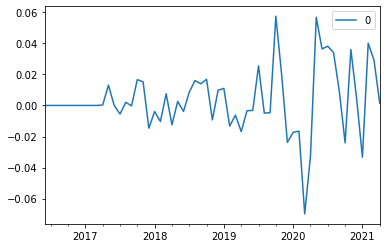

In [5]:
# overall basket return
total_return.plot()

Text(0.5, 1.0, 'Monthly return')

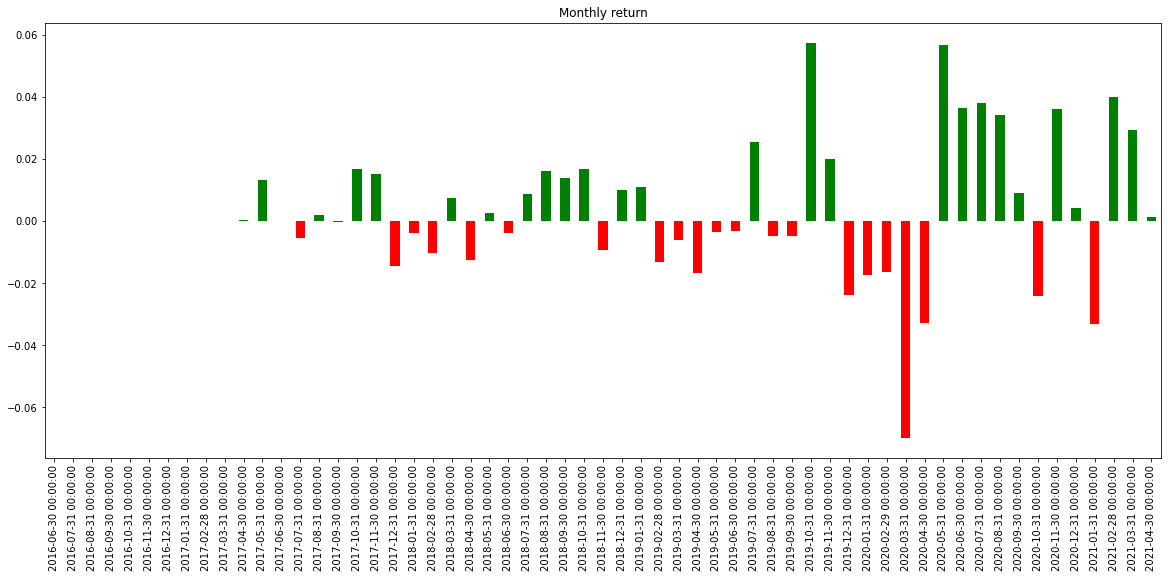

In [6]:
# plotting relative monthly return
fig = plt.figure()
total_return['pos'] = total_return > 0 
total_return[0].plot(kind = 'bar',
                    color = total_return.pos.map({True : 'g' , False : 'r'}),
                    figsize= (20,8))
plt.title('Monthly return')

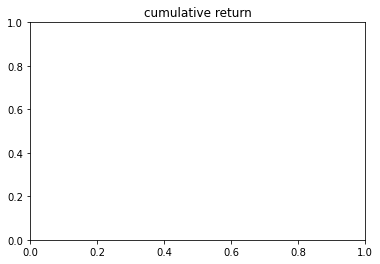

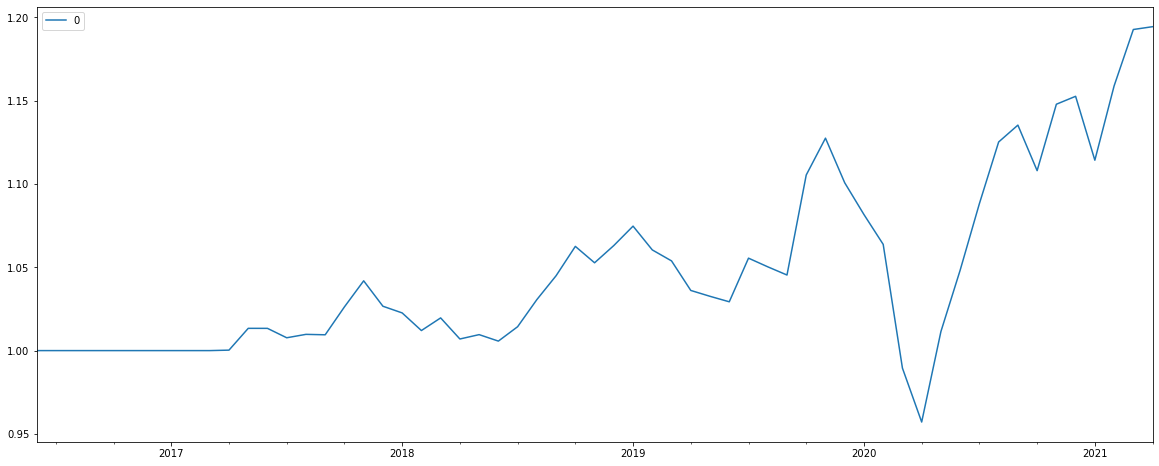

In [7]:
# plotting cumulative portfolio value over the year. 
fig2 = plt.figure()
plt.title ('cumulative return')
cumlative_return.plot(figsize = (20,8))
plt.show()


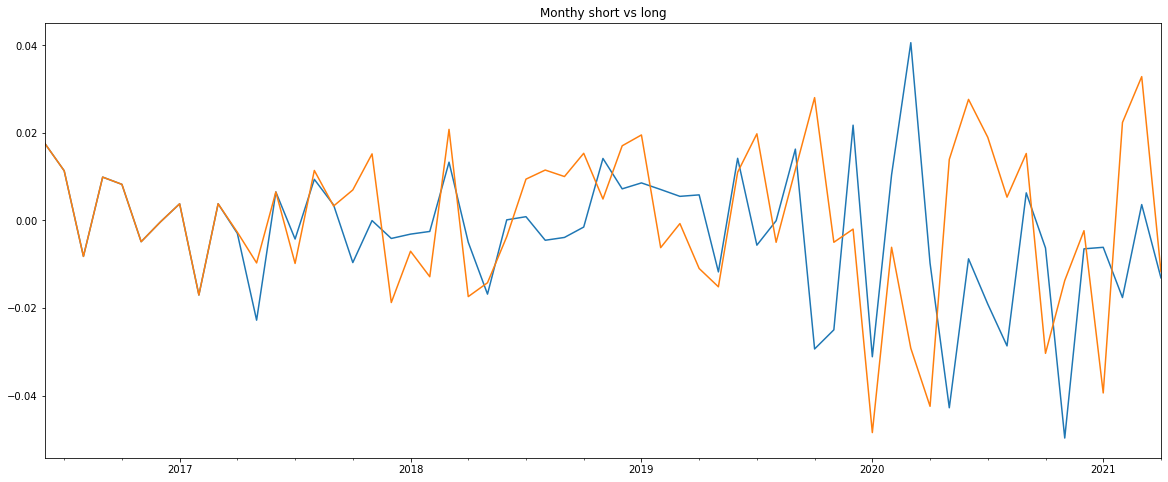

In [8]:
# Plotting long and short basket return.
fig3 = plt.figure()
plt.title('Monthy short vs long')
shrt_returns.mean(1).plot(figsize = (20,8), label = 'short')
long_returns.mean(1).plot(label = 'Long')
plt.show()


In [9]:
combined_return = pd.merge(long_returns, shrt_returns, left_index=True, right_index=True, suffixes=('_long','_shrt'))
total_return = []
for i in range(len(combined_return)):
    sum_of_returns = combined_return.iloc[i,:].sum()
    total_return.append(sum_of_returns)
combined_return_basket = pd.DataFrame(total_return, columns=['Total Return'],index=combined_return.index)

<AxesSubplot:>

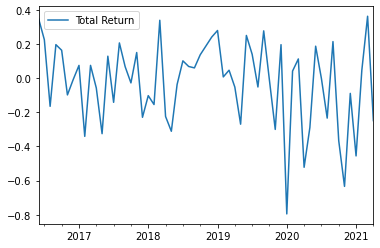

In [10]:
combined_return_basket.plot()